In [2]:
jupyter kernelspec list

SyntaxError: invalid syntax (<ipython-input-2-68dcfb427789>, line 1)

In [ ]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [ ]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We only support sklearn and pytorch.

# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from skimage import exposure
import numpy as np
import imutils
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import random
import seaborn as sns
from torch import nn


In [ ]:
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
rndm_state = 42

Helpers


In [ ]:
def identity_func(foo):
    return foo


#
#
# ------- Your Code -------
#
#

# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.6, 1.0)

# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model 
# "n_val" is number of instances in test or validation sets
def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28))).astype(np.uint8)
            ax[j][i].imshow(two_d)
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)


    plt.tight_layout()
    
def vis_predictions_for_cnn(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (x_eval[ids[(i*rows)+j]])
            ax[j][i].imshow(two_d)
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)
    
         


    plt.tight_layout()     

#  Loading and Visualizing data



In [ ]:
import torchvision.transforms as transforms
import torch
import torchvision
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# if not exist, download mnist dataset
x_trainval_n = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True) 

y_trainval_n = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True) 

x_trainval_nf = (x_trainval_n.data).cpu().detach().numpy()


y_trainval = (x_trainval_n.targets).cpu().detach().numpy()  # tensor to np.array

x_test_nf =   (y_trainval_n.data).cpu().detach().numpy() 

y_test = (y_trainval_n.targets).cpu().detach().numpy()   # tensor to np.array

(x_trainval_nf, x_eval_nf_g, y_trainval, y_eval_g) = train_test_split(x_trainval_nf, y_trainval,
	test_size=0.1, random_state=84)

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval_nf.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test_nf.shape, y_test.shape))
print(x_eval_nf_g.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

x_trainval.shape = (54000, 28, 28),  y_trainval.shape = (54000,)
x_test.shape = (10000, 28, 28),  y_test.shape = (10000,)
(6000, 28, 28)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### 1.2. Visualize Data


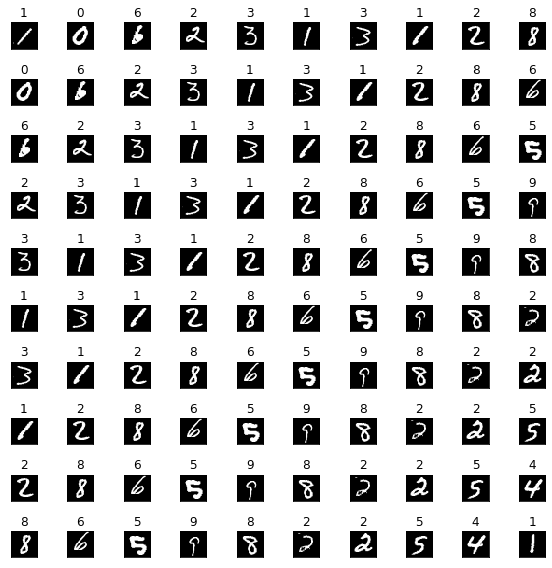

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


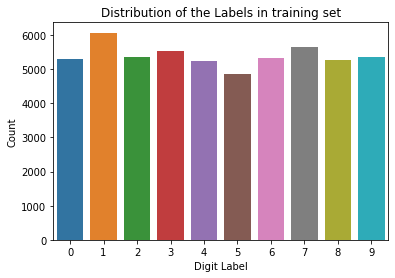

In [ ]:
# Visualize 10 examples of 10 classes. You can extend the following code:
rows, cols = 10, 10
fig,ax = plt.subplots(nrows = rows, ncols = cols,figsize=(8,8))

#
#
# ------- Your Code -------
#
#
num =10
# train_data_reshape = x_trainval.reshape(x_trainval.shape[0], 28, 28)

for i in range(num):
  for j in range(num):
    axes = ax[i, j]
    # axes.imshow(train_data_reshape[i+j], cmap='gray')
    axes.imshow(x_trainval_nf[i+j], cmap='gray')
    axes.set_title('{}'.format(y_trainval[i+j]))
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

# plt.figure()
# plt.hist(y_trainval, bins='auto')  # arguments are passed to np.histogram
# plt.title("Histogram with distribution of the labels in the images")
ax = sns.countplot(y_trainval);
ax.set(title="Distribution of the Labels in training set", xlabel="Digit Label", ylabel="Count");
# You can see an output example in the follow:

#  Digit classifiers









## Model [M1]: k-Nearest Neighbors

K-NN (K-Nearest Neighbours) is one of the most basic algorithms in supervised learning. Here, we do not learn weights from training data to predict output (as in model-based algorithms) but use entire training instances to predict output for unseen data. Model is not learned using training data prior and the learning process is postponed to a time when prediction is requested on the new instance. We use sklearn library and KNeighborsClassifier implementation. Euclidean distance metric is used as it is a measure of true line distance between two points in euclidean. For predicting class for a new data point it finds new data point’s ‘K’ Nearest Neighbors (Data points) from feature space and their class labels and assigns label accordingly. We have cross validated the model with different k-values (hyperparameter values k = 1, 4, 7, 10, 13) using validation set. We chose this model as the training data is large. We chose the model with k value which gave best validation accuracy and predicted the test labels using that model.

### Hyper-parameters

Hyper-parameters for the  model is defined here

In [ ]:
#
#
# ------- Your Code -------
#
#

kVals = range(1, 15, 3)
accuracies = []
degree = np.asarray([1,2,3]) # example


test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation
# now, let's take 10% of the training data and use that for validation


if test_set == 'val':
    # train_idxs, val_idxs = ..., ...   # Fill in
    # x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    # x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
    x_eval_nf, y_eval = x_eval_nf_g, y_eval_g

else:
    # x_train, y_train = x_trainval, y_trainval
    # x_eval, y_eval = x_test, y_test
    x_eval_nf, y_eval = x_test_nf, y_test


###  Data Preprocessing


In [ ]:
#
#
# ------- Your Code -------
#
# e.g. normalize, flatten input data.
x_trainval =flatten_input_pixels(x_trainval_nf)
x_test =flatten_input_pixels(x_test_nf)
x_eval =flatten_input_pixels(x_eval_nf)
print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
print('x_eval.shape = {},  y_eval.shape = {}'.format(x_eval.shape, y_eval.shape))

x_trainval.shape = (54000, 784),  y_trainval.shape = (54000,)
x_test.shape = (10000, 784),  y_test.shape = (10000,)
x_eval.shape = (10000, 784),  y_eval.shape = (10000,)


###  Model

Different models with varying k values has been saved

In [ ]:
#
#
# ------- Your Code -------
#
for k in range(1, 15, 3):
  # train the k-Nearest Neighbor classifier with the current value of `k`
  model = KNeighborsClassifier(n_neighbors=k)
  # save the model to disk
  filename = 'model'+str(k)+'.sav'
  pickle.dump(model, open(filename, 'wb'))

###  Fit Model

Different models with varying k values were used fit to the data

In [ ]:
#
#
# ------- Your Code -------
#
# 
#  Please save the trained model
# loop over various values of `k` for the k-Nearest Neighbor classifier
for k in range(1, 15, 3):
  # train the k-Nearest Neighbor classifier with the current value of `k`
  model = pickle.load(open('model'+str(k)+'.sav', 'rb'))
  model.fit(x_trainval, y_trainval)
  # save the model to disk
  filename = 'model'+str(k)+'.sav'
  pickle.dump(model, open(filename, 'wb'))
	

###Evaluation



Models with different k-values are loaded and evaluated against validation dataset

In [ ]:
#
#
# ------- Your Code -------
#
# Example: y_pred = model.predict(x)
# evaluate the model and update the accuracies list
for k in range(1, 15, 3):
  # load the model from disk
  model = pickle.load(open('model'+str(k)+'.sav', 'rb'))
  score = model.score(x_eval, y_eval)
  print("k=%d, accuracy=%.2f%%" % (k, score * 100))
  accuracies.append(score)

k=1, accuracy=97.24%
k=4, accuracy=97.00%
k=7, accuracy=96.96%
k=10, accuracy=96.74%
k=13, accuracy=96.48%


Plotting the k-values against validation accuracies

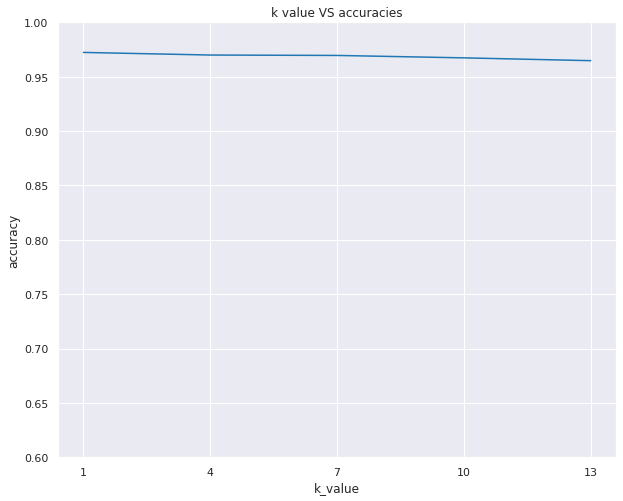

In [ ]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.

# Example: plot_scores(parameters, scores, "title", "x_label", "y_label"), 

# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations. 
# We encourage more informative and alternate methods to present results.

sns.set_context("notebook")
sns.set_style("darkgrid")
plot_scores(kVals,accuracies,"k value VS accuracies","k_value","accuracy")

Finding the best model against validation set

In [ ]:
# Here report the score for the best model
#
# ------- Your Code -------
#
# find the value of k that has the largest accuracy
best_accuracy_knn = int(np.argmax(accuracies))
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[best_accuracy_knn],
	accuracies[best_accuracy_knn] * 100))

k=1 achieved highest accuracy of 97.24% on validation data


After the above step we need to re-run the hyper parameters block and data pre-processing block to assign x_eval value to x_test.

test accuracy=96.70%


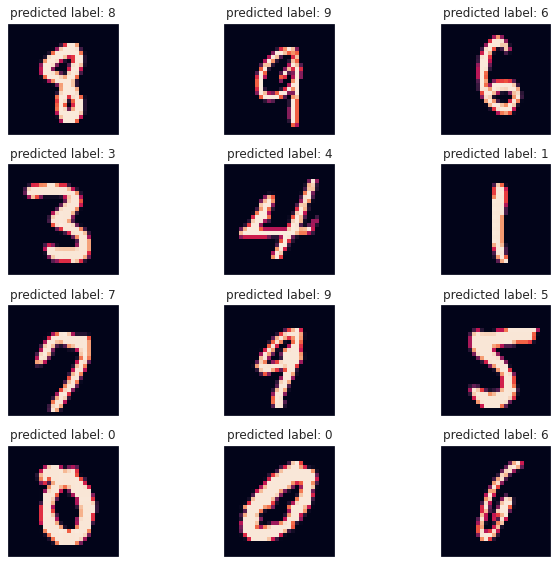

In [ ]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
#
# ------- Your Code -------
#
model = pickle.load(open('model'+str(kVals[best_accuracy_knn])+'.sav', 'rb'))
score = model.score(x_eval, y_eval)
print("Test accuracy=%.2f%%" % (score * 100))
y_pred = model.predict(x_eval)
vis_predictions(x_eval,y_pred,x_eval.shape[0])

### Summary

KNN is non-parametric algorithm which means it doesnt make any assumptions on underlying data. In KNN the most important hyperparameter is the k-value which states how many near points will be compared. Choosing a low k will lead to an more precise result but the complexity will also increase and Chosing a high k will lead in generalized models but will also loose information. In order to find the suitable k value for this task we calculated the validation accuracies on models with different k values. For our case k=1 with euclidean distance metric yielded a better validation accuracy has been used to make predictions on test data.

kNN is easy to implement because it only requires k and distance metric, besides, there is no training phase. However, for large datasets, the cost of calculating distance between new point and each existing point becomes higher and testing time gets greater as well.
 

# Model [M2]: Support vector machine

We use an SVM classifier with linear kernel to perform the multiclass classification task. We use sklearn library and LinearSVC implementation. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is a number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well. Hyperparameter in our SVM model is cost C. We have cross validated the model with 9 different cost values from 0.0001 to 10000. C defines the weight of how much samples inside the margin contribute to the overall error. With C one can adjust how hard or soft the large margin classification should be.

### Hyper-parameters

Hyper-parameters are defined here

In [ ]:
#
#
# ------- Your Code -------
#
#
cost= [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
degree = np.asarray([1,2,3]) # example


# You don't need the following code, if you can use data from 2.1.1.

test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    # train_idxs, val_idxs = ..., ...   # Fill in
    # x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    # x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
    x_eval_nf, y_eval = x_eval_nf_g, y_eval_g

else:
    # x_train, y_train = x_trainval, y_trainval
    # x_eval, y_eval = x_test, y_test
    x_eval_nf, y_eval = x_test_nf, y_test

###  Data Preprocessing
No need of data processing here for our model

In [ ]:
#
#
# ------- Your Code -------
#
# e.g. normalize, flatten input data.
x_trainval =flatten_input_pixels(x_trainval_nf)
x_test =flatten_input_pixels(x_test_nf)
x_eval =flatten_input_pixels(x_eval_nf)
print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))
print('x_eval.shape = {},  y_eval.shape = {}'.format(x_eval.shape, y_eval.shape))

x_trainval.shape = (54000, 784),  y_trainval.shape = (54000,)
x_test.shape = (10000, 784),  y_test.shape = (10000,)
x_eval.shape = (10000, 784),  y_eval.shape = (10000,)


###  Model

LinearSVM model is created for different C values 

In [ ]:

for c in cost:
    model = LinearSVC(dual=False, C=c)
    # save the model to disk
    filename = 'model_svm'+str(c)+'.sav'
    pickle.dump(model, open(filename, 'wb'))

### Fit Model


Fitting models on training data for different cost values and savind the models

In [ ]:
#
#
# ------- Your Code -------
#
# 
#  Please save the trained model
for c in cost:
    model = pickle.load(open('model_svm'+str(c)+'.sav', 'rb'))
    model.fit(x_trainval, y_trainval)
    # save the model to disk
    filename = 'model_svm'+str(c)+'.sav'
    pickle.dump(model, open(filename, 'wb'))

###  Evaluation




Cross-validating models on validation data for different cost values.

In [ ]:
accuracies = []
for c in cost:
  # load the model from disk
  model = pickle.load(open('model_svm'+str(c)+'.sav', 'rb'))
  y_predict = model.predict(x_eval)
  score = accuracy_score(y_eval,y_predict)
  print("c=%f, accuracy=%.2f%%" % (c, score * 100))
  accuracies.append(score)

c=0.000100, accuracy=90.92%
c=0.001000, accuracy=91.18%
c=0.010000, accuracy=91.20%
c=0.100000, accuracy=91.22%
c=1.000000, accuracy=91.13%
c=10.000000, accuracy=91.17%
c=100.000000, accuracy=91.15%
c=1000.000000, accuracy=91.18%
c=10000.000000, accuracy=91.23%


Plotting Cost values against validation-accuarcy

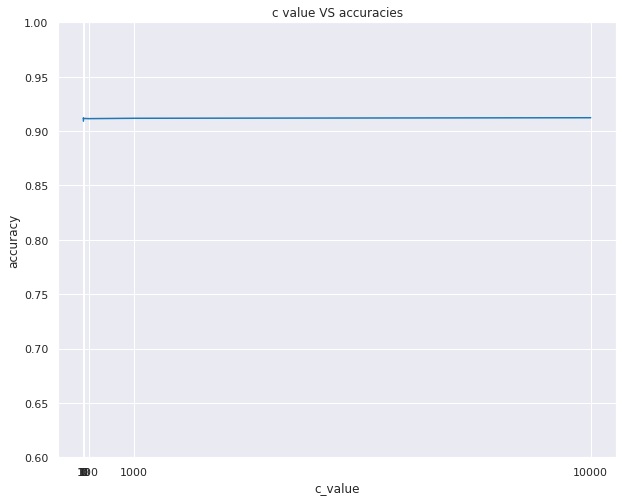

In [ ]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.

# Example: plot_scores(parameters, scores, "title", "x_label", "y_label"), 

# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations. 
# We encourage more informative and alternate methods to present results.
sns.set_context("notebook")
sns.set_style("darkgrid")
plot_scores(cost,accuracies,"c value VS accuracies","c_value","accuracy")

Finding best model

In [ ]:
# Here report the score for the best model
#
# ------- Your Code -------
#
best_accuracy_svm = int(np.argmax(accuracies))
print("c=%f achieved highest accuracy of %.2f%% on validation data" % (cost[best_accuracy_svm],
	accuracies[best_accuracy_svm] * 100))

c=10000.000000 achieved highest accuracy of 91.23% on validation data


After the above step we need to re-run the hyper parameters block to assign x_eval value to x_test.

test accuracy=91.73%


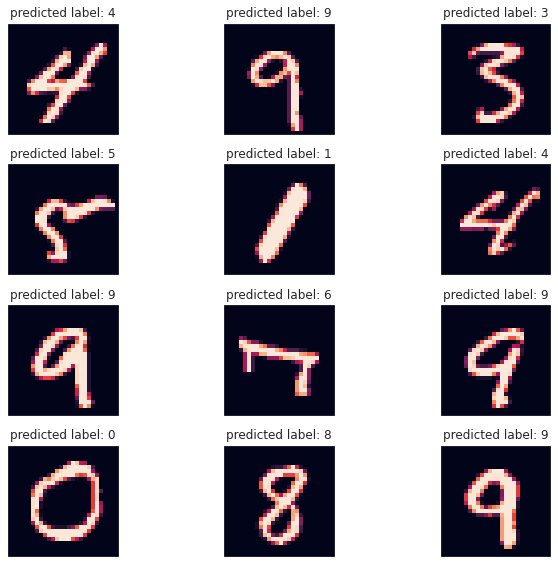

In [ ]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
#
# ------- Your Code -------
#
model = pickle.load(open('model_svm'+str(cost[best_accuracy_svm])+'.sav', 'rb'))
y_pred = model.predict(x_eval)
score = accuracy_score(y_eval,y_pred)
print("test accuracy=%.2f%%" % (score * 100))
vis_predictions(x_eval,y_pred,x_eval.shape[0])

### Summary

The hyperparameters for SVM classifier that were important were the paramaters C, and gamma. But in our model we varied C parameter. As we saw from the plots above, the C parameter influenced our results. We can see from the cross-validation results and the validation plots that for C value of 10000 has the highest validation accuracy. With a low C, samples inside the margins are penalized less than with a higher C. However, in our case C value variation did not create that much of an effect. 

We tried Polynomial and Radial basis function kernels, but since dataset is large, training time is is considerably higher. Therefore we preferred linear kernel. Maybe training time and model complexity could be improved by implementing a more robust preprocessing, for instance, using a feature extraction technique or reducing data dimensionality.

# Model [M3] (Neural Networks): 

We used two hidden layer convolution neural network to perform the multiclass classification task. We used pytorch to create the CNN model. We tried three different values for learning rate, learning rate decay and regularization parameter with dropout and without dropout. At last out of the six models we got, we chose the model which gave highest validation accuracy and used the test data for prediction.

###  Hyper-parameters

Hyper-parameters are defined here

In [ ]:
input_size =  1
hidden_layers = [20,144]
num_classes = 10
num_epochs = 10
batch_size = 2000
learning_rate = [1e-3, 1e-2,1e-1]
learning_rate_decay = [0.95, 0.85,0.75]
reg= [0.001, 0.01, 0.1]
num_training= 50000
num_validation =10000
dropout = "yes"

val_accu = []
val_accu_data = 0
last = 0
loss_ar = []
valid_losses = []
count =0
valid_losses_sum = 0
train_accu = []
correct_train = 0
total_train = 0
best_accuracy = 0
loss_values = []


test_set = 'val'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation
if test_set == 'val':
    mask = list(range(num_training))
    train_dataset = torch.utils.data.Subset(x_trainval_n, mask)
    mask = list(range(num_training, num_training + num_validation))
    val_dataset = torch.utils.data.Subset(x_trainval_n, mask) 
else:
    y_trainval_n = y_trainval_n
print(len(train_dataset),len(val_dataset))    

50000 10000


### Data Preprocessing


Train, Test and Validation data sets are given to dataloader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader_nn = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader_nn = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader_nn = torch.utils.data.DataLoader(dataset=y_trainval_n,
                                          batch_size=batch_size,
                                          shuffle=False)


cuda


###  Model

CNN model is defined here

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, dropout):
        super(Net, self).__init__()
        self.layers = []
        if dropout == "no":
          self.layers.append(nn.Conv2d(input_size,hidden_layers[0],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(stride = 1, kernel_size = 2))
          self.layers.append(nn.Conv2d(hidden_layers[0],hidden_layers[1],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(kernel_size = 2, stride = 1))
          #self.layers.append(nn.Linear(hidden_layers[1],num_classes))
          self.layers = nn.Sequential(*self.layers)
          #self.f = nn.flatten()
          self.fc = nn.Sequential(nn.Linear(46656,num_classes))
          # self.fc2 = nn.Sequential(nn.Softmax())
          self.fullnn = [self.layers,self.fc]
        else:
          self.layers.append(nn.Conv2d(input_size,hidden_layers[0],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(stride = 1, kernel_size = 2))
          self.layers.append(nn.Dropout(0.5))
          self.layers.append(nn.Conv2d(hidden_layers[0],hidden_layers[1],5))
          self.layers.append(nn.ReLU())
          self.layers.append(nn.MaxPool2d(kernel_size = 2, stride = 1))
          self.layers.append(nn.Dropout(0.5))
          #self.layers.append(nn.Linear(hidden_layers[1],num_classes))
          self.layers = nn.Sequential(*self.layers)
          #self.f = nn.flatten()
          self.fc = nn.Sequential(nn.Linear(46656,num_classes))
          # self.fc2 = nn.Sequential(nn.Softmax())
          self.fullnn = [self.layers,self.fc]

    def forward(self, x):
     
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        out1 = (self.fc(x))
      
        return out1

Functions for initializing weights and updating learning rate is defined here

In [ ]:
#initialization of weights for conv2d layers

def weights_init(m):
    if type(m) == nn.Conv2d:
        m.weight.data.normal_(0.0, 1e-3)

#update learning rate after one step of backprop        
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

###  Fit Model


Defining models with and without dropout

In [ ]:
model = Net(input_size, hidden_layers, num_classes, dropout).to(device)
model_withdropout = Net(input_size, hidden_layers, num_classes, "yes").to(device)
print(model_withdropout)

#PrintModelSize(model,True)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(20, 144, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=46656, out_features=10, bias=True)
  )
)


Defining a training function

In [ ]:
def train_model(dropout_s,model,learning_rate,reg,train_loader_nn,val_loader_nn,best_accuracy,num_epochs,total_train,correct_train,train_acc,val_accu_data,val_accu,learning_rate_decay,train_accu,loss_values):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    lr = learning_rate
    total_step = len(train_loader_nn)
    # print(total_step)
    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(train_loader_nn):

           images = images.to(device)
           labels = labels.to(device)

        # Forward pass
           outputs = model(images)

           loss = criterion(outputs, labels)
          #  print(i)
        # Backward and optimize
           optimizer.zero_grad()
           loss.backward()
           optimizer.step()
        
           loss_ar.append(loss.item())
           if (i+1) % 25 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
              _, predicted_train = torch.max(outputs.data, 1)
              loss_values.append(loss.item())
              total_train += labels.size(0)
              correct_train += (predicted_train == labels).sum().item() 
              # print(total_train,correct_train) 

        train_accu.append(100 * correct_train / total_train)
        correct_train = 0
        total_train = 0
    # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader_nn:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                #############
            print('Validataion accuracy is: {} %'.format(100 * correct / total))
            val_accu_data = (100 * correct) / total
            print(type(val_accu))
            val_accu.append(val_accu_data)
            # if val_accu_data < last:
            #     count+= 1
            # else:
            #     count = 0
            # last = val_accu_data
            # cur_accuracy = val_accu_data
            # if val_accu_data > best_accuracy:
            #     best_accuracy = val_accu_data
            #     best_model = model
            #     print("best")
            #     torch.save(best_model.state_dict(),'./best_model.ckpt')
    

        model.train()
    if(val_accu[num_epochs-1]> best_accuracy):
        best_accuracy = val_accu[num_epochs-1]
        torch.save(model.state_dict(),'./best_model'+str(dropout_s)+'.ckpt')                         
        print("best model with val acc"+ str(val_accu[num_epochs-1])+ "is saved")
    return   val_accu,val_accu[num_epochs-1],train_accu,best_accuracy,loss_values

Defining a test function

In [ ]:
def test(test_loader_nn,model):
   
   with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader_nn:
          
          images = images.to(device)
         
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          # if total == 1000:
          #     break

      print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))
   return test_loader_nn,predicted
      
  

Training 3 models with three different hyperparameters for learning rate, learning rate decay and regularization without droupout.

In [ ]:
# Save your model using torch.save()
#print(type(val_accu))
models_list = []
last_val_accu_across_epochs = []
train_accu_across_epochs = []
val_acc_whole_data = []
loss_history_list = []
dropout_s = 'no'
for iters in range(0,len(learning_rate)):
  model.apply(weights_init)
  print("model weights initialized")
  val_acc_list,val_accu,train_accu, best, loss_history = train_model(dropout_s,model,learning_rate[iters],reg[iters],train_loader_nn,val_loader_nn,best_accuracy,num_epochs,total_train,correct_train,train_accu,val_accu_data,val_accu,learning_rate_decay[iters],train_accu,loss_values)
  best_accuracy = best
  last_val_accu_across_epochs.append(val_accu)
  train_accu_across_epochs.append(train_accu)
  val_acc_whole_data.append(val_acc_list)
  loss_history_list.append(loss_history)
  val_accu = []
  train_accu = []
  loss_values = []


model weights initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Step [25/25], Loss: 1.3088
Validataion accuracy is: 71.17 %
<class 'list'>
Epoch [2/10], Step [25/25], Loss: 0.6472
Validataion accuracy is: 85.21 %
<class 'list'>
Epoch [3/10], Step [25/25], Loss: 0.4772
Validataion accuracy is: 87.95 %
<class 'list'>
Epoch [4/10], Step [25/25], Loss: 0.3469
Validataion accuracy is: 92.49 %
<class 'list'>
Epoch [5/10], Step [25/25], Loss: 0.1904
Validataion accuracy is: 96.04 %
<class 'list'>
Epoch [6/10], Step [25/25], Loss: 0.1147
Validataion accuracy is: 96.84 %
<class 'list'>
Epoch [7/10], Step [25/25], Loss: 0.1357
Validataion accuracy is: 97.51 %
<class 'list'>
Epoch [8/10], Step [25/25], Loss: 0.1032
Validataion accuracy is: 97.87 %
<class 'list'>
Epoch [9/10], Step [25/25], Loss: 0.1128
Validataion accuracy is: 97.97 %
<class 'list'>
Epoch [10/10], Step [25/25], Loss: 0.1008
Validataion accuracy is: 97.9 %
<class 'list'>
best model with val acc97.9is saved
model weights initialized
Epoch [1/10], Step [25/25], Loss: 0.3686
Validat

Training 3 models with three different hyperparameters for learning rate, learning rate decay and regularization with droupout.

In [ ]:
# Save your model using torch.save()
#print(type(val_accu))
models_list = []
last_val_accu_across_epochs_dp = []
train_accu_across_epochs_dp = []
val_acc_whole_data_dp = []
loss_history_list_dp = []
dropout_s = 'yes'
for iters in range(0,len(learning_rate)):
  model.apply(weights_init)
  print("model weights initialized")
  val_acc_list,val_accu,train_accu, best, loss_history = train_model(dropout_s,model_withdropout,learning_rate[iters],reg[iters],train_loader_nn,val_loader_nn,best_accuracy,num_epochs,total_train,correct_train,train_accu,val_accu_data,val_accu,learning_rate_decay[iters],train_accu,loss_values)
  best_accuracy = best
  last_val_accu_across_epochs_dp.append(val_accu)
  train_accu_across_epochs_dp.append(train_accu)
  val_acc_whole_data_dp.append(val_acc_list)
  loss_history_list_dp.append(loss_history)
  val_accu = []
  train_accu = []
  loss_values = []


model weights initialized
Epoch [1/10], Step [25/25], Loss: 0.4452
Validataion accuracy is: 88.53 %
<class 'list'>
Epoch [2/10], Step [25/25], Loss: 0.2146
Validataion accuracy is: 94.68 %
<class 'list'>
Epoch [3/10], Step [25/25], Loss: 0.1635
Validataion accuracy is: 96.66 %
<class 'list'>
Epoch [4/10], Step [25/25], Loss: 0.1176
Validataion accuracy is: 97.31 %
<class 'list'>
Epoch [5/10], Step [25/25], Loss: 0.1112
Validataion accuracy is: 97.59 %
<class 'list'>
Epoch [6/10], Step [25/25], Loss: 0.0905
Validataion accuracy is: 97.96 %
<class 'list'>
Epoch [7/10], Step [25/25], Loss: 0.0774
Validataion accuracy is: 98.18 %
<class 'list'>
Epoch [8/10], Step [25/25], Loss: 0.0955
Validataion accuracy is: 98.18 %
<class 'list'>
Epoch [9/10], Step [25/25], Loss: 0.0504
Validataion accuracy is: 98.33 %
<class 'list'>
Epoch [10/10], Step [25/25], Loss: 0.0577
Validataion accuracy is: 98.47 %
<class 'list'>
best model with val acc98.47is saved
model weights initialized
Epoch [1/10], Step [

From the below code cell we will get to know the best model with highest validation accuracy for model without dropout and with dropout. Later we compare the those two models for validation accuracy and select the model with highest validation accuracy for prediction

In [ ]:
good_model_index = last_val_accu_across_epochs.index(max(last_val_accu_across_epochs))
print("model with learning_rate of " + str(learning_rate[good_model_index]) + " learning_rate_decay of " + str(learning_rate_decay[good_model_index])+
                              " regularization of "+ str(reg[good_model_index])+ " has best val accuracy and has been saved") 

good_model_index_dp = last_val_accu_across_epochs_dp.index(max(last_val_accu_across_epochs_dp))
print("model with droupout with learning_rate of " + str(learning_rate[good_model_index_dp]) + " learning_rate_decay of " + str(learning_rate_decay[good_model_index_dp])+
                              " regularization of "+ str(reg[good_model_index_dp])+ " has best val accuracy and has been saved") 
print("Best validation accuracy for model with dropout " + str(max(last_val_accu_across_epochs_dp)))
print("Best validation accuracy for model without dropout " + str(max(last_val_accu_across_epochs)))

model with learning_rate of 0.01 learning_rate_decay of 0.85 regularization of 0.01 has best val accuracy and has been saved
model with droupout with learning_rate of 0.001 learning_rate_decay of 0.95 regularization of 0.001 has best val accuracy and has been saved
Best validation accuracy for model with dropout 98.47
Best validation accuracy for model without dropout 98.16


Plotting loss and epochs

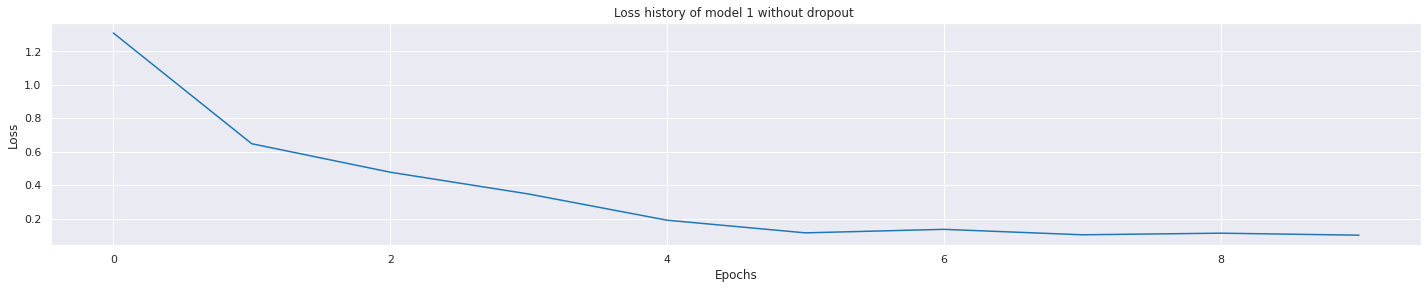

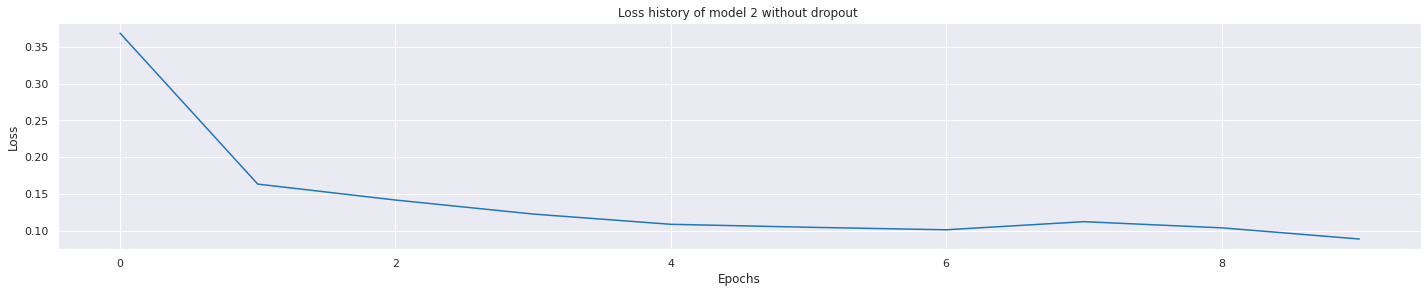

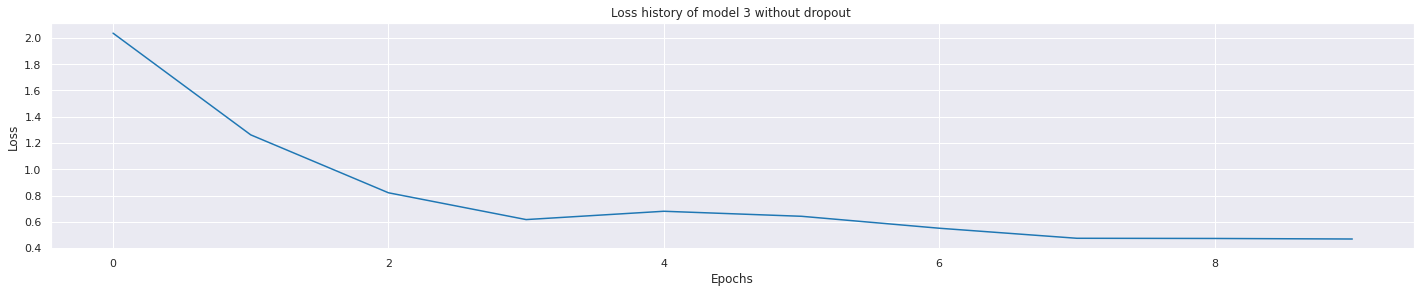

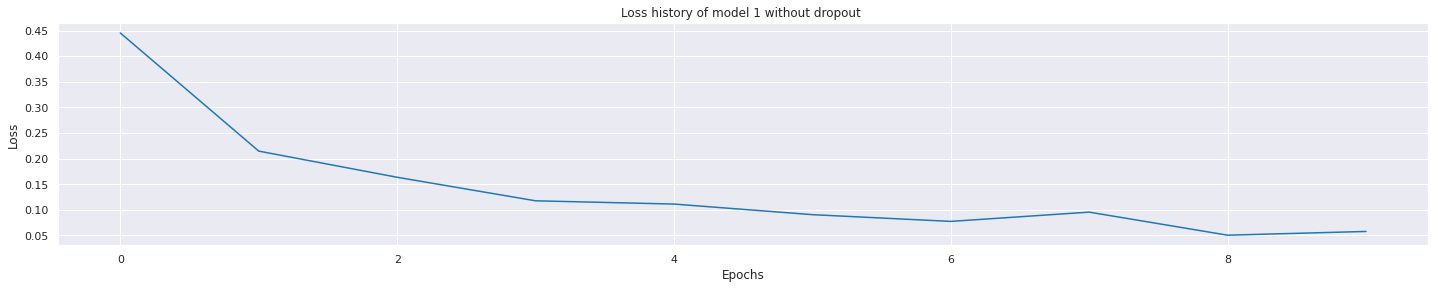

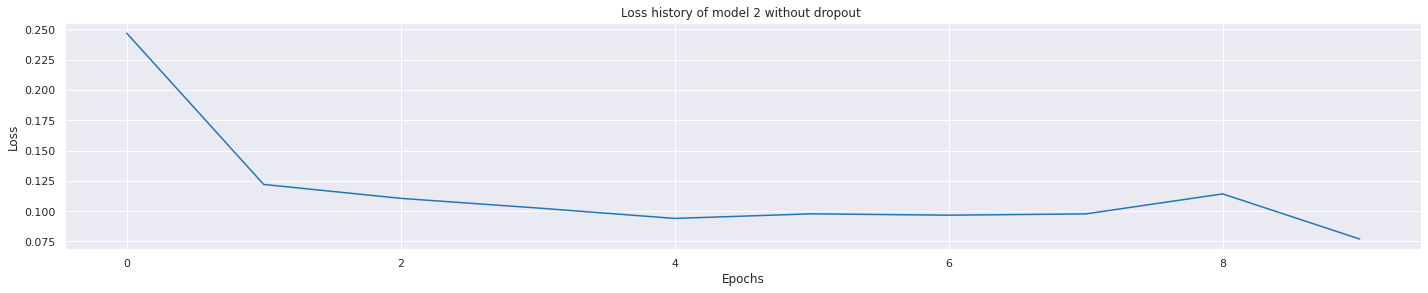

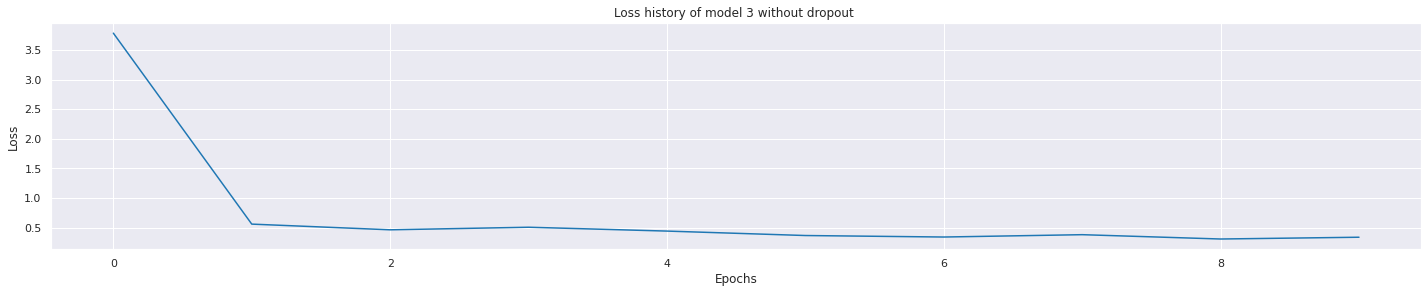

In [ ]:
# Here plot epoch (# passes over training data) and loss
#
# ------- Your Code -------
sns.set_context("notebook")
sns.set_style("darkgrid")
for i in range(0,len(reg)):
  plt.figure(figsize=(20,15))
  plt.subplot(len(reg)+1, 1, i+1)
  plt.plot(loss_history_list[i])
  plt.title('Loss history of model ' + str(i+1) + " without dropout ")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  

  plt.tight_layout()
  plt.show()

for i in range(0,len(reg)):
  plt.figure(figsize=(20,15))
  plt.subplot(len(reg)+1, 1, i+1)
  plt.plot(loss_history_list_dp[i])
  plt.title('Loss history of model ' + str(i+1) + " without dropout ")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  

  plt.tight_layout()
  plt.show()    



Plotting epoch and validation and train accuracies

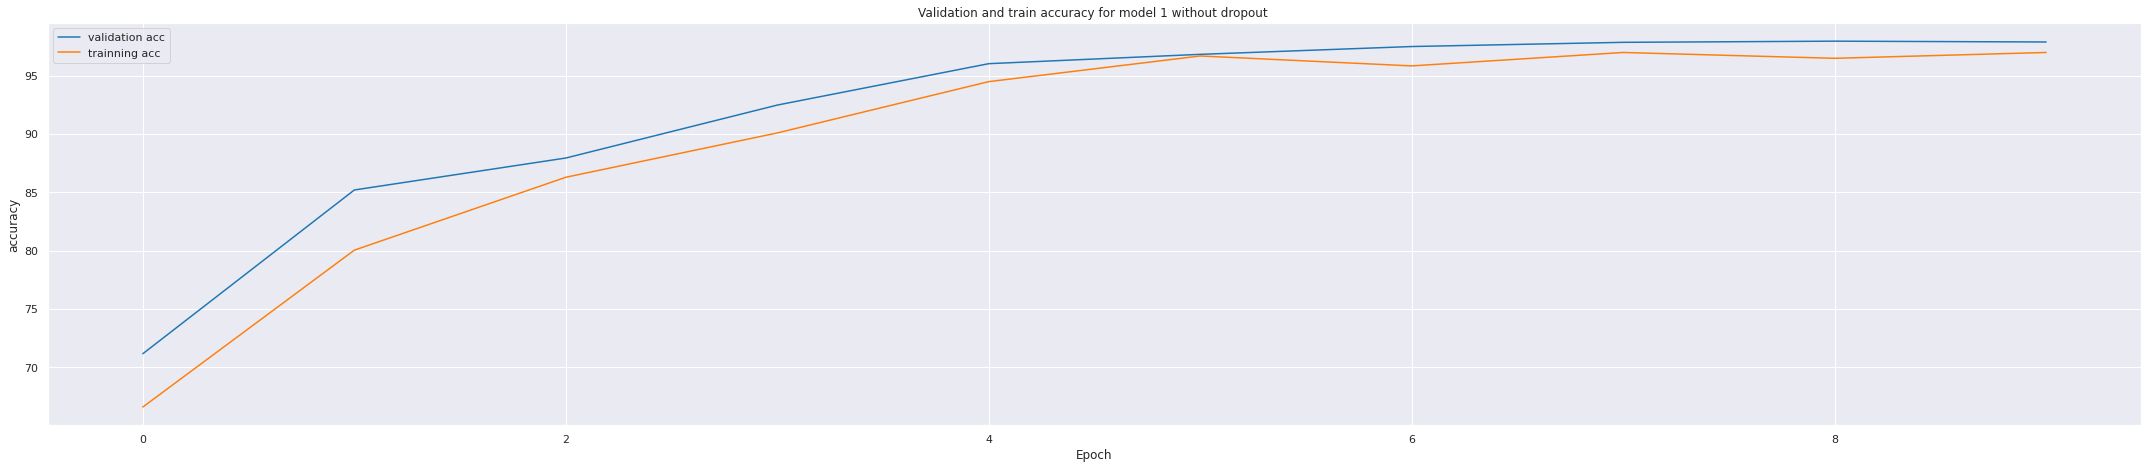

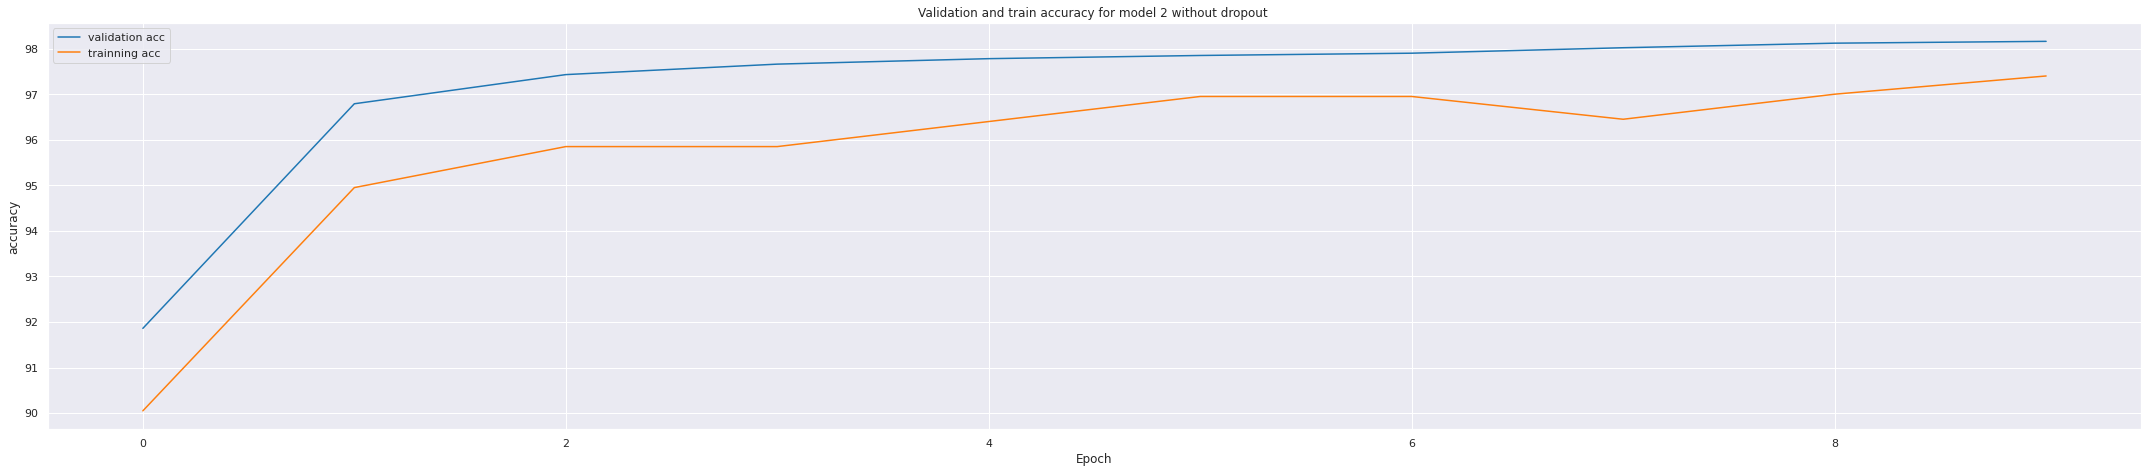

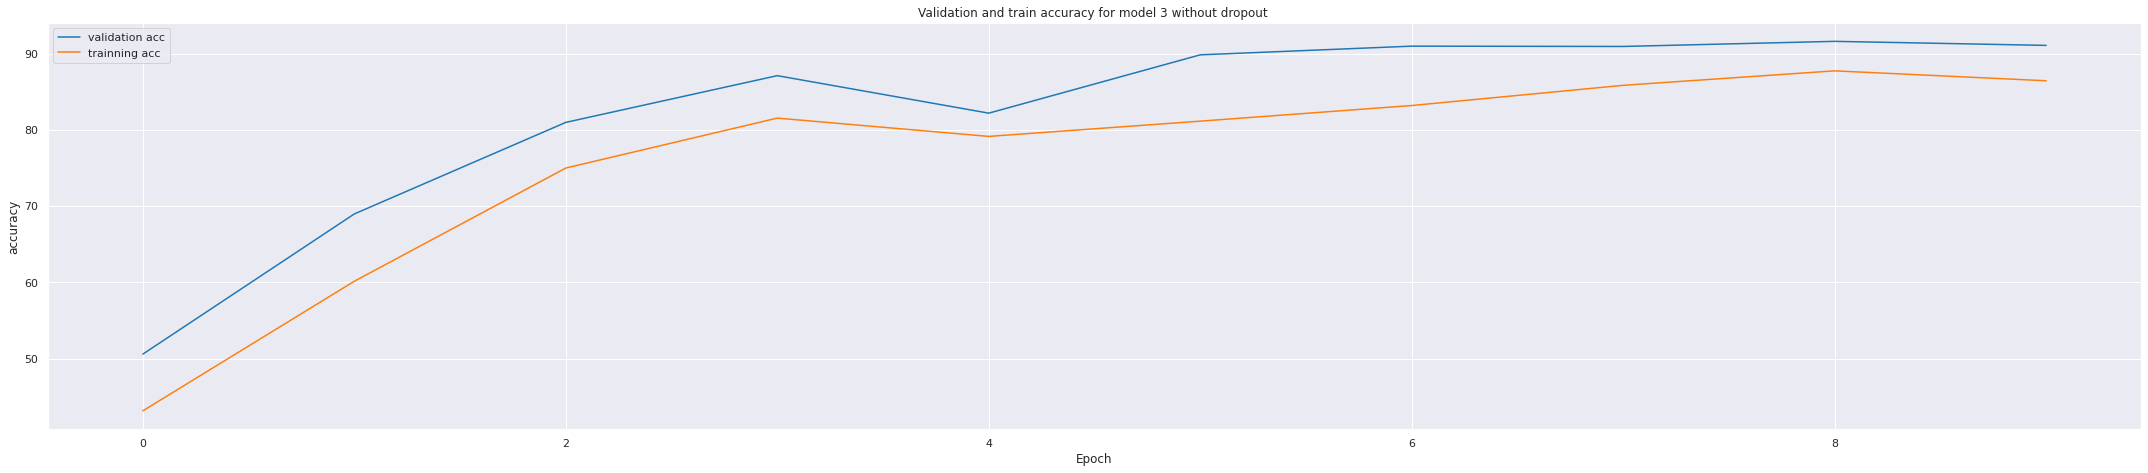

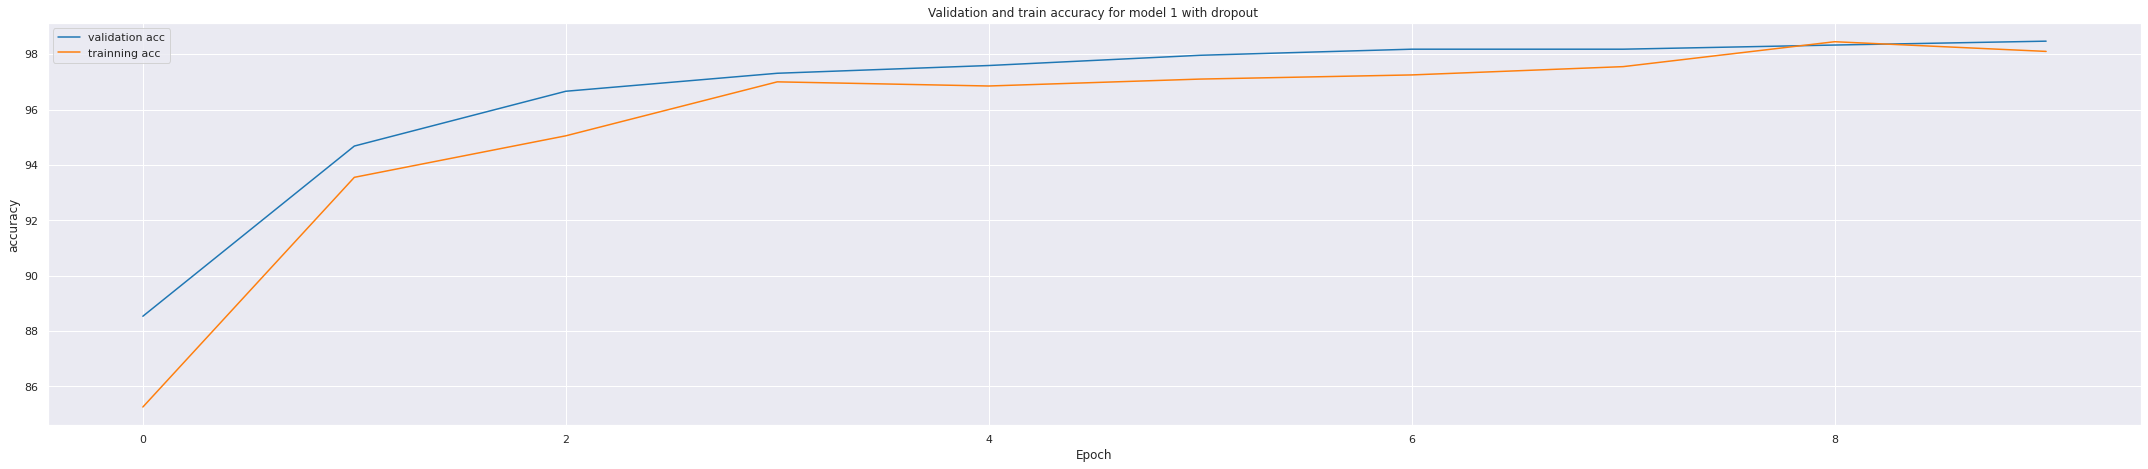

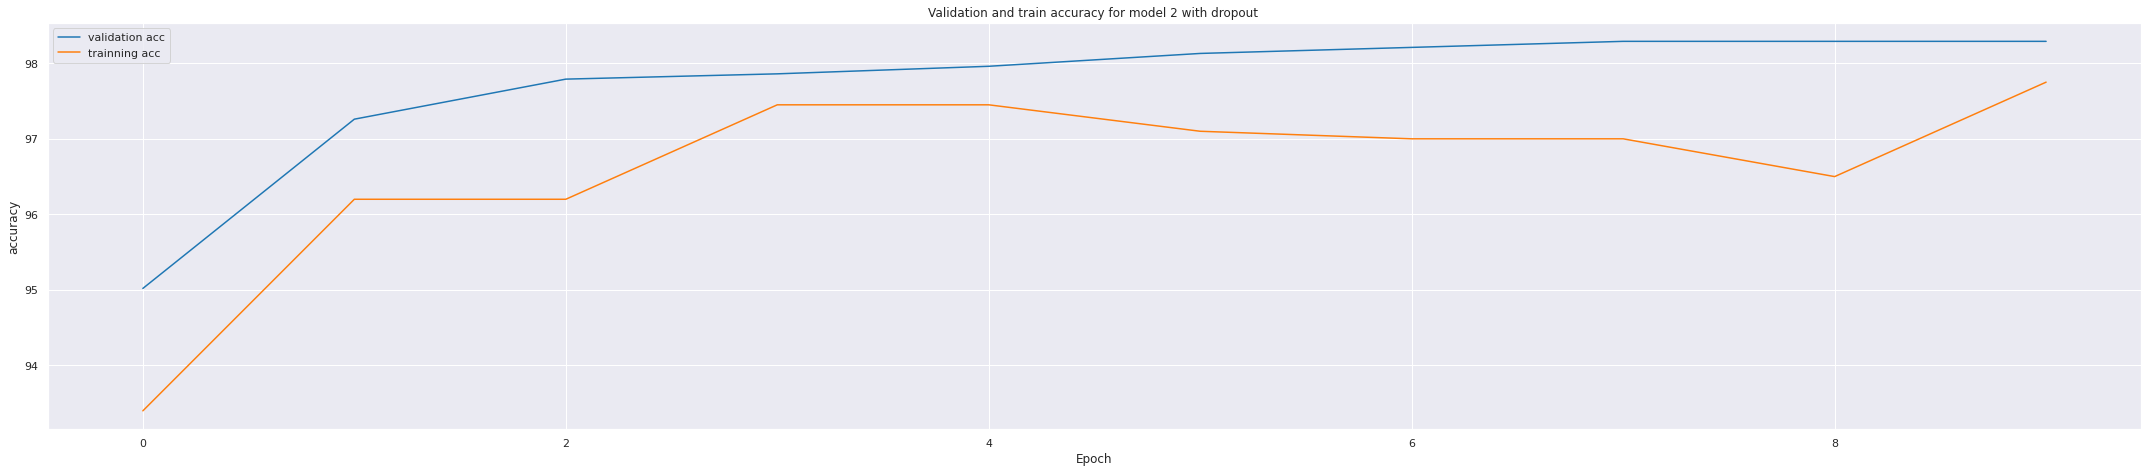

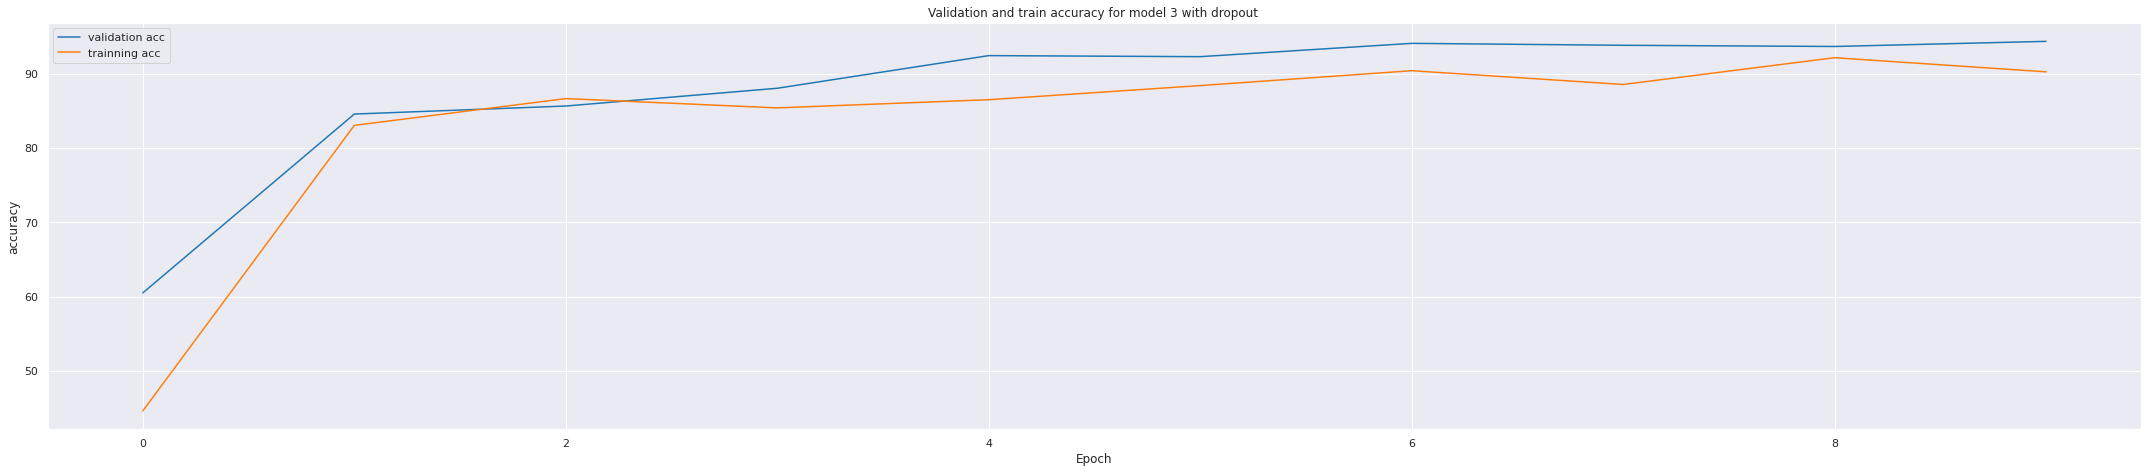

In [ ]:

#
# ------- Your Code -------
for i in range(0,len(reg)):
  plt.figure(figsize=(30,25))
  plt.subplot(len(reg)+1, 1, i+1)

  plt.plot(val_acc_whole_data[i])
  plt.title("Validation and train accuracy for model "+ str(i+1)+ " without dropout ")
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')

  plt.plot(train_accu_across_epochs[i])
  plt.legend(['validation acc', 'trainning acc'])


  plt.tight_layout()
  plt.show()
    
for i in range(0,len(reg)):
  plt.figure(figsize=(30,25))
  plt.subplot(len(reg)+1, 1, i+1)

  plt.plot(val_acc_whole_data_dp[i])
  plt.title("Validation and train accuracy for model "+ str(i+1)+ " with dropout ")
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')

  plt.plot(train_accu_across_epochs_dp[i])
  plt.legend(['validation acc', 'trainning acc'])

  

  plt.tight_layout()
  plt.show()    

We load the best saved model

In [ ]:
#
#
# ------- Your Code -------
model_withdropout.eval()
model_withdropout.load_state_dict(torch.load('./best_modelyes.ckpt'))

<All keys matched successfully>

Here we predict the best model on the test set

In [ ]:
# Here report the score for the best model
#
# ------- Your Code -------
#
test_loader_nn,predicted = test(test_loader_nn,model_withdropout)



Accuracy of the network on the 10000 test images: 98.63 %


Here we visualize the predictions

torch.Size([2000, 1, 28, 28]) 	 torch.Size([2000])


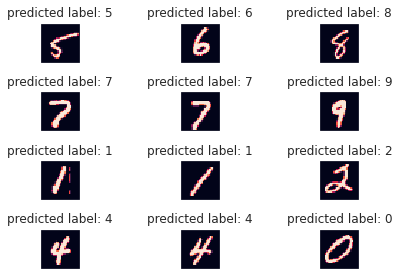

In [ ]:
# Visualize the predictions
i =0
images_list = []
for image , label in test_loader_nn:
   i = i + 1
   if (i == 5):
    print(image.size() , '\t' , label.size())
    for r in range(0,2000):
      im = image[r]
      images_list.append(im)
test_images = torch.cat(images_list) 
#predicted = predicted.cpu().detach().numpy()  
vis_predictions_for_cnn(test_images.numpy(), predicted, 2000)

###  Summary

Important hyperparameters for CNN classifier are the number of epochs, filter size, optimizer algorithm, non-linear activation, learning rate and dropout rate. Number of epochs helps the model to learn the data better. With this, the model was able to train for much larger time and the accuracy increased. For this task 10 epochs worked good. Dropout is used as a regularizer to generalize the model. The model with dropout gave the best validation accuracy. Our choices while performing this task include number of hidden convolution layers to use. We first tried  with one convolution layer and then tried two convolution layers. With two convolution layers it felt the model performed better than the model with one layer as it represents the data better. So in our task we only considered two layer convolution model with a fully connect layer at the end and varied the hyper parameters. The other choice is to use dropout or not. Model with dropout gave best validation accuracy, but the difference of accuracy to the model without dropout with same hyperparameters as dropout is not very high. As in most of CNN's maxpool is used as standard  to reduce input size and accomodate for the increase in features, we have also used maxpooling in our model.
 

# overall Summary



We plot the accuracies of the different models below.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


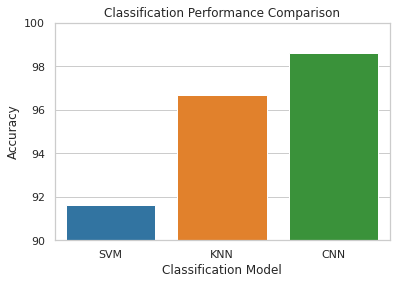

In [ ]:
sns.set_style('whitegrid')
ax = sns.barplot(['SVM','KNN','CNN'],[91.63,96.70,98.63]);
ax.set(title="Classification Performance Comparison", xlabel="Classification Model", ylabel="Accuracy",ylim=(90,100));

kNN and SVM are amongst the most popularly used classification models. Neural Networks are also highly being used nowadays because of the accuracy that they provide. We can compare these three models using time taken to train data, time taken to predict over test data and accuracy. kNN takes lesser time to train over data compared to SVM and CNN. SVM and CNN take a significant training time, but require minimal computation for classification on test data.Evaluation time for kNN is larger than of SVM and CNN. Of all the three models in our task it is found that CNN>KNN>SVM considering accuracies. Also the number of hyperparameters required to tune kNN is also primarily just the value of K where as it is possible to refine the SVM and Neural Network models with more hyperparameters. This makes it easier for the models to learn over the range of training data. Compared to the other two models, CNN handles large data relatively well and thus is normally used as best model to extract good features and classify the images correctly. We also believe that with the use of proper data augumentation which provides extra data to the model by random cropping, random rotation etc and adding couple more convolution layers, we can bring the test accuracy to 99.5%


